In [1]:
import numpy as np
import glob
import pickle
import cv2 as cv
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

In [2]:
classes = {
    "without_mask": 0,
    "with_mask": 1,
    "mask_worn_incorrect": 2
}

In [3]:
def load_dataset(path, label, labels = classes):
    paths = glob.glob("./" + path + "/"  + label + "/*")
    paths.sort()
    return np.array([np.array(cv.imread(p)) for p in paths]), np.array([labels[label] for p in paths])

def load_resized_dataset(path, label, labels = classes):
    paths = glob.glob("./" + path + "/"  + label + "/*")
    paths.sort()
    return np.array([np.array(cv.resize(cv.imread(p), (224, 224), interpolation=cv.INTER_CUBIC)) for p in paths]), np.array([labels[label] for p in paths])

def load_double_resized_dataset(path, label, labels = classes):
    paths = glob.glob("./" + path + "/" + label + "/*")
    paths.sort()
    return np.array([np.array(double_resize(cv.imread(p))) for p in paths]), [labels[label] for p in paths]

def load_gray_dataset(label, labels = classes):
    paths = glob.glob("./face-mask-dataset/"  + label + "/*")
    paths.sort()
    return [np.array(cv.cvtColor(cv.imread(p), cv.COLOR_BGR2GRAY)) for p in paths], [labels[label] for p in paths]

def load_images_rgb(path):
    paths = glob.glob(path + "/*")
    paths.sort()
    return [np.array(cv.imread(p)) for p in paths]

def load_images(path):
    paths = glob.glob(path + "/*")
    paths.sort()
    return [np.array(cv.cvtColor(cv.imread(p), cv.COLOR_BGR2GRAY)) for p in paths]

def extract_hog(image, ppc = 16):
    features, _ = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    return features

def double_resize(image, first_size = (30, 30), target_size = (224, 224)):
    resized = cv.resize(image, (first_size), interpolation = cv.INTER_CUBIC)
    return cv.resize(resized, (target_size), interpolation = cv.INTER_CUBIC)

In [5]:
mask, mask_labels = load_gray_dataset("with_mask")
no_mask, no_mask_labels = load_gray_dataset("without_mask")
mask_incorrect, mask_incorrect_labels = load_gray_dataset("mask_worn_incorrect")

print(len(mask), len(mask_labels))
print(len(no_mask), len(no_mask_labels))
print(len(mask_incorrect), len(mask_incorrect_labels))

images = np.concatenate((mask, no_mask, mask_incorrect))
labels = np.concatenate((mask_labels, no_mask_labels, mask_incorrect_labels))
print(len(images), len(labels))

for i in images:
    assert(i.shape == (128, 128))

2994 2994
2994 2994
2994 2994
8982 8982


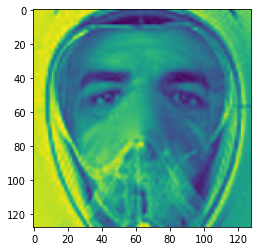

In [23]:
plt.imshow(mask[0]);

In [124]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.75, shuffle=True)

In [125]:
hog_train = [extract_hog(image) for image in x_train]

In [43]:
model = svm.SVC()
parameters = [{
    "C": [0.1, 1, 10],
    "kernel": ["poly"],
    "degree": [2, 3, 4, 5],
    "gamma": [0.05, 0.025]
}, {
    "C": [0.1, 1, 10],
    "kernel": ["rbf"],
    "gamma": [0.05, 0.025]
}]
n_folds = 3
grid_search_cv = GridSearchCV(model, parameters, cv=n_folds)

grid_search_cv.fit(hog_train, y_train)
print(grid_search_cv.best_params_)

{'C': 10, 'degree': 3, 'gamma': 0.025, 'kernel': 'poly'}


In [126]:
clf = svm.SVC(C=10, degree=3, gamma=0.025, kernel="poly")
clf.fit(hog_train, y_train)

SVC(C=10, gamma=0.025, kernel='poly')

In [127]:
hog_test = [extract_hog(image) for image in x_test]
clf.score(hog_test, y_test)

0.9807102148180622

In [61]:
filename = "SVC-model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(clf, file)

In [5]:
filename = "SVC-model.pkl"
with open(filename, 'rb') as file:
    clf = pickle.load(file)

In [144]:
faces = load_images_rgb("faces")
resized_faces = [cv.resize(f, (128, 128), interpolation=cv.INTER_CUBIC) for f in faces]

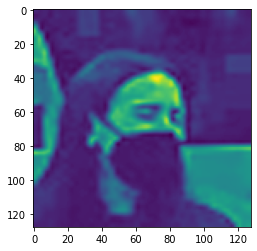

In [12]:
plt.imshow(resized_faces[2])

In [15]:
hog_faces = [extract_hog(f) for f in resized_faces]
print(clf.score(hog_faces,  [1 for i in range(len(faces))]))
results = clf.predict(hog_faces)

In [30]:
print([e for e in zip([i for i, c in enumerate(results) if c != 1],
    [c for c in results if c != 1])])

[(10, 0), (15, 0), (18, 0), (21, 2), (25, 0), (28, 0), (48, 0), (51, 0), (124, 0), (127, 0), (131, 0)]


In [14]:
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [15]:
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

maxpool = tf.keras.layers.GlobalMaxPooling2D()(mobilenet.output)
output = tf.keras.layers.Dense(3, activation='softmax')(maxpool)
model = tf.keras.Model(inputs=[mobilenet.input], outputs=[output])
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
one_hot_encoding = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1]
}

mask = tf.keras.applications.mobilenet_v2.preprocess_input(mask)
no_mask = tf.keras.applications.mobilenet_v2.preprocess_input(no_mask)
mask_incorrect = tf.keras.applications.mobilenet_v2.preprocess_input(mask_incorrect)

labels = mask_labels + no_mask_labels + mask_incorrect_labels
labels = np.array([one_hot_encoding[i] for i in labels])

print(len(images), len(labels))
for i in images:
    assert(i.shape == (224, 224, 3))

2994 2994
2994 2994
2994 2994
8982 8982


In [17]:
mask, mask_labels = load_double_resized_dataset("face-mask-dataset", "with_mask")
no_mask, no_mask_labels = load_double_resized_dataset("face-mask-dataset", "without_mask")
mask_incorrect, mask_incorrect_labels = load_double_resized_dataset("face-mask-dataset", "mask_worn_incorrect")

our_mask, our_mask_labels = load_dataset("faces", "with_mask")
our_no_mask, our_no_mask_labels = load_dataset("faces", "without_mask")
our_mask_incorrect, our_mask_incorrect_labels = load_dataset("faces", "mask_worn_incorrect")

print(len(mask), len(mask_labels))
print(len(no_mask), len(no_mask_labels))
print(len(mask_incorrect), len(mask_incorrect_labels))
print(len(our_mask), len(our_mask_labels))
print(len(our_no_mask), len(our_no_mask_labels))
print(len(our_mask_incorrect), len(our_mask_incorrect_labels))

one_hot_encoding = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1]
}

images = np.concatenate((mask, no_mask, mask_incorrect))
faces = np.concatenate((our_mask, our_no_mask, our_mask_incorrect))
labels = np.concatenate((mask_labels, no_mask_labels, mask_incorrect_labels))
faces_labels = np.concatenate((our_mask_labels, our_no_mask_labels, our_mask_incorrect_labels))
labels = np.array([one_hot_encoding[i] for i in labels])
faces_labels = np.array([one_hot_encoding[i] for i in faces_labels])
images = np.array([cv.resize(i, (224, 224)) for i in images])
faces = np.array([cv.resize(i, (224, 224)) for i in faces])
images = np.concatenate((images, faces))
labels = np.concatenate((labels, faces_labels))
images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
print(len(images), len(labels))
for i in images:
    assert(i.shape == (224, 224, 3))

/usr/local/Caskroom/miniforge/base/envs/var/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


2994 2994
2994 2994
2994 2994
114 114
227 227
41 41
9364 9364


In [5]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, shuffle=True, random_state=0)

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='mobilenet_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5')
]

In [20]:
history = model.fit(x=x_train,
            y=y_train,
            validation_split=0.2,
            epochs=30,
            callbacks=callbacks
)

Epoch 1/30
188/188 [==============================] - 199s 1s/step - loss: 0.3787 - accuracy: 0.8934 - val_loss: 0.4620 - val_accuracy: 0.8726
Epoch 2/30
188/188 [==============================] - 199s 1s/step - loss: 0.0314 - accuracy: 0.9880 - val_loss: 0.3707 - val_accuracy: 0.9039
Epoch 3/30
188/188 [==============================] - 197s 1s/step - loss: 0.0187 - accuracy: 0.9932 - val_loss: 0.2695 - val_accuracy: 0.9346
Epoch 4/30
188/188 [==============================] - 197s 1s/step - loss: 0.0115 - accuracy: 0.9957 - val_loss: 0.2542 - val_accuracy: 0.9306
Epoch 5/30
188/188 [==============================] - 195s 1s/step - loss: 0.0086 - accuracy: 0.9967 - val_loss: 0.1642 - val_accuracy: 0.9573
Epoch 6/30
188/188 [==============================] - 194s 1s/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.1363 - val_accuracy: 0.9673
Epoch 7/30
188/188 [==============================] - 196s 1s/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.1429 - val_accuracy: 0.9633

In [152]:
model.save("mobilenet-face-mask-detection-model")

2022-02-12 00:41:36.930142: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mobilenet-model/assets


In [13]:
faces = load_images_rgb("faces")
faces = np.array([cv.resize(f, (224, 224)) for f in faces])
faces = tf.keras.applications.mobilenet_v2.preprocess_input(faces)


In [150]:
model.evaluate(faces, np.array([(0, 1, 0) for i in range(len(faces))]))

5/5 [==============================] - 2s 352ms/step - loss: 0.0092 - accuracy: 1.0000


[0.009233017452061176, 1.0]

In [151]:
model.evaluate(x_test, y_test)

57/57 [==============================] - 28s 495ms/step - loss: 0.0415 - accuracy: 0.9905


[0.04154375568032265, 0.9905397891998291]

In [6]:
loaded = tf.keras.models.load_model("mobilenet_epoch-05_loss-0.0063_val_loss-0.0767.h5")


2022-02-15 11:16:25.311735: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-02-15 11:16:25.364371: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd751105790 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-15 11:16:25.364384: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [12]:
loaded.evaluate(x_test, y_test)

59/59 [==============================] - 44s 753ms/step - loss: 0.0898 - accuracy: 0.9733


[0.08980125933885574, 0.9733048677444458]

# **Performance Evaluation**

In [5]:
loaded = tf.keras.models.load_model("models/mobilenet_epoch-08_loss-0.0027_val_loss-0.1257.h5")

2022-03-02 10:19:48.503041: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-02 10:19:48.503087: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-02 10:19:48.503118: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (simone-81nc): /proc/driver/nvidia/version does not exist
2022-03-02 10:19:48.503562: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-03-02 10:19:48.538605: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2295585000 Hz
2022-03-02 10:19:48.540031: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcd24000b60 initialized for platform Host (this does not guarantee tha

In [6]:
mask, mask_labels = load_resized_dataset("faces", "with_mask")
no_mask, no_mask_labels = load_resized_dataset("faces", "without_mask")
incorrect_mask, incorrect_mask_labels = load_resized_dataset("faces", "mask_worn_incorrect")

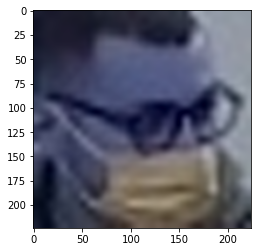

In [7]:
plt.imshow(mask[0])

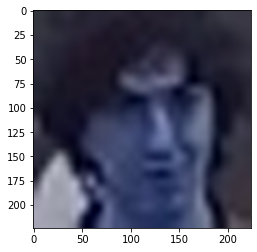

In [7]:
plt.imshow(no_mask[0])

In [8]:
def evaluate_dataset(images, labels):
    right, wrong = evaluate(images, labels)

    print("Dataset:", len(images))
    print("Right predictions:", len(right))
    print("Wrong predictions:", len(wrong))
    return right, wrong

def evaluate(images, labels):
    predictions = loaded.predict(images)
    
    right = []
    wrong = []

    for image, pred, label in zip(images, predictions, labels):
        guess = np.argmax(pred)
        if guess == label:
            right.append((image, pred))
        else:
            wrong.append((image, guess, pred[guess], label))
    
    return right, wrong

def wrong_analysis(wrong_predictions):
    original_labels = np.array([p[3] for p in wrong_predictions])
    originally0 = wrong_predictions[original_labels == 0]
    originally1 = wrong_predictions[original_labels == 1]
    originally2 = wrong_predictions[original_labels == 2]
    single_class_wrong_analysis(originally0, 0)
    single_class_wrong_analysis(originally1, 1)
    single_class_wrong_analysis(originally2, 2)

def single_class_wrong_analysis(wrong_predictions, label):
    if len(wrong_predictions) > 0:
        next = (label + 1) % 3
        other = (next + 1) % 3
        first_class = []
        second_class = []
        for img, guess, pred, l in wrong_predictions:
            if guess == next:
                first_class.append(guess)
            else:
                second_class.append(guess)

        total = len(wrong_predictions)
        
        print("Analyzing",total , "images of class", label)
        print(len(first_class), "images where classified as", next, "(", len(first_class) / total * 100.0, "% )")
        print(len(second_class), "images where classified as", other, "(", len(second_class) / total * 100.0, "% )")


def dataset_performance_evaluation(images, labels):
    right, wrong = evaluate_dataset(images, labels)
    print("Accuracy:", len(right) / len(images))
    print("Wrong percentage:", len(wrong) / len(images))
    wrong_analysis(np.array(wrong))


In [9]:
dataset_performance_evaluation(mask, mask_labels)
dataset_performance_evaluation(no_mask, no_mask_labels)
dataset_performance_evaluation(incorrect_mask, incorrect_mask_labels)

2022-03-02 10:20:01.480366: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 17160192 exceeds 10% of free system memory.
2022-03-02 10:20:03.891692: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 19267584 exceeds 10% of free system memory.
2022-03-02 10:20:03.900562: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 19440000 exceeds 10% of free system memory.
2022-03-02 10:20:03.915264: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 51380224 exceeds 10% of free system memory.
2022-03-02 10:20:04.005532: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 51380224 exceeds 10% of free system memory.


Dataset: 114
Right predictions: 113
Wrong predictions: 1
Accuracy: 0.9912280701754386
Wrong percentage: 0.008771929824561403
Analyzing 1 images of class 1
0 images where classified as 2 ( 0.0 % )
1 images where classified as 0 ( 100.0 % )


/tmp/ipykernel_3813/4218463917.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wrong_analysis(np.array(wrong))


Dataset: 227
Right predictions: 91
Wrong predictions: 136
Accuracy: 0.4008810572687225
Wrong percentage: 0.5991189427312775
Analyzing 136 images of class 0
136 images where classified as 1 ( 100.0 % )
0 images where classified as 2 ( 0.0 % )
Dataset: 41
Right predictions: 0
Wrong predictions: 41
Accuracy: 0.0
Wrong percentage: 1.0
Analyzing 41 images of class 2
3 images where classified as 0 ( 7.317073170731707 % )
38 images where classified as 1 ( 92.6829268292683 % )


In [7]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label'.format(accuracy, misclass))
    plt.show()

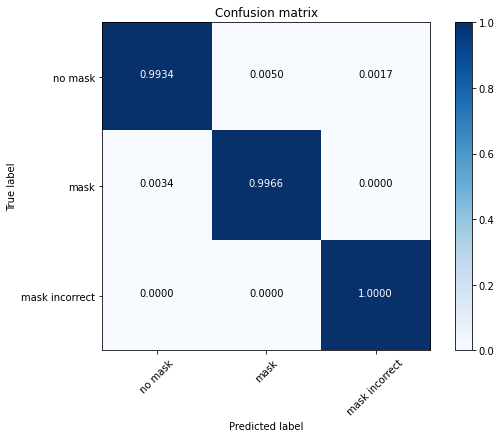

In [12]:
from sklearn.metrics import confusion_matrix

predictions = loaded.predict(x_test)
matrix = confusion_matrix([np.argmax(y) for y in y_test], [np.argmax(y) for y in predictions], normalize = "true")
plot_confusion_matrix(matrix, ["no mask", "mask", "mask incorrect"])

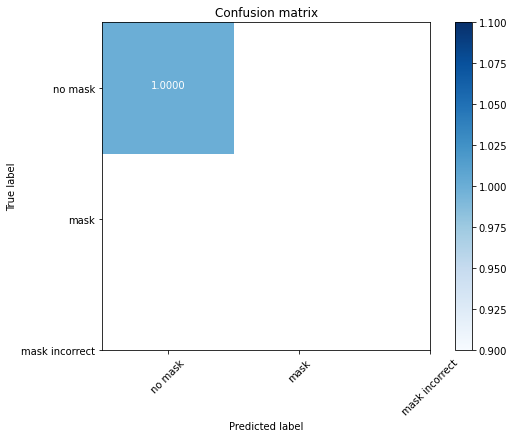

In [14]:
from sklearn.metrics import confusion_matrix

predictions = loaded.predict(faces)
matrix = confusion_matrix([1 for _ in faces], [np.argmax(y) for y in predictions], normalize = "true")
plot_confusion_matrix(matrix, ["no mask", "mask", "mask incorrect"])